# CMIP6 Hackathon: Sea ice and temperature sensitivity

October 2019  
Maddie Smith, Robin Clancy, Katie Brennan, Ed Blanchard-Wrigglesworth  


In [1]:
%matplotlib inline

import xarray as xr
import intake
import matplotlib.pyplot as plt
import numpy as np

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util
import siutils

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col

In [3]:
col.df.columns

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year'],
      dtype='object')

In [4]:
import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [5]:
cat_siconc = col.search(experiment_id=['historical'],table_id='SImon', 
                        variable_id='siconc', grid_label='gn')

In [6]:
cat_cellarea = col.search(experiment_id=['historical'],table_id='Ofx', 
                          variable_id='areacello', grid_label='gn')

In [7]:
cat_tas = col.search(experiment_id=['historical'],table_id='Amon', 
                          variable_id='tas', grid_label='gn')

#### Find variables models that contain certain variables

In [8]:
models_intersect = set(uni_dict['source_id']['values']) # all the models
table_id = ['SImon','Ofx','Amon']
var_list = ['siconc','areacello','tas']
exp = 'historical'

models_intersect = siutils.find_overlap_models(var_list,exp,table_id,models_intersect,col)

### Load data: 

In [9]:
decode_setting = False

In [10]:
ardset_dict = cat_cellarea.to_dataset_dict(zarr_kwargs={'consolidated': True, 
                                                        'decode_times': decode_setting},
                                           cdf_kwargs={'chunks': {}, 'decode_times': decode_setting})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 13 group(s)


In [11]:
sidset_dict = cat_siconc.to_dataset_dict(zarr_kwargs={'consolidated': True, 
                                                      'decode_times': decode_setting}, 
                                         cdf_kwargs={'chunks': {}, 'decode_times': decode_setting})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


In [12]:
tasdset_dict = cat_tas.to_dataset_dict(zarr_kwargs={'consolidated': True, 
                                                    'decode_times': decode_setting}, 
                                         cdf_kwargs={'chunks': {}, 'decode_times': decode_setting})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


In [13]:
amodel_name_dict = {ardset_dict[x].attrs['source_id']: x for x in ardset_dict}
smodel_name_dict = {sidset_dict[x].attrs['source_id']: x for x in sidset_dict}
tmodel_name_dict = {tasdset_dict[x].attrs['source_id']: x for x in tasdset_dict}

In [14]:
si_dicti = {}
tas_dict = {}

for key, item in sidset_dict.items():
    model = item.attrs['source_id']
    if model in models_intersect: 
        si_dicti[model] = item
        si_dicti[model]['areacello'] = ardset_dict[amodel_name_dict[model]]['areacello']
        tas_dict[model] = tasdset_dict[tmodel_name_dict[model]]

### Calculate total Arctic sea ice area: 

In [15]:
# Rename dimensions so they're all the same: 
si_dict = {}
for m in models_intersect:
    si_dict[m] = siutils.rename_dimensions(si_dicti[m],si_dict)

In [16]:
# Calculate total area: 
m=models_intersect[0]
si_dict[m]['si_area'] = si_dict[m].areacello*si_dict[m].siconc/100.0
si_dict[m]['si_area'].attrs['units'] = si_dict[m].areacello.attrs['units']

si_dict[m]['si_area_tot_arc'] = si_dict[m].si_area.where(
    si_dict[m].latitude>0).sum(dim=['i','j'])/(1000*1000)
si_dict[m]['si_area_tot_arc'].attrs['units'] = 'km2'

#### Calculate extent: 

In [32]:
# *** BUG time dimension doesn't seem to be carried over ***
# si_dict[m]['si_extent_test']=si_dict[m].siconc.where((si_dict[m].siconc>15),0)
# si_dict[m]['si_extent']=si_dict[m].si_extent_test.where((si_dict[m].si_extent_test<10),1)
# si_dict[m]['si_extent_nh']=si_dict[m].si_extent.where((si_dict[m].j>0),0)

# si_dict[m]['si_extent_tot_nh'] = (si_dict[m].si_extent_nh*si_dict[m].areacello).sum(dim=['i','j'])/(1000*1000)
# si_dict[m]['si_extent_tot_nh'].attrs['units'] = 'km2'

In [144]:
si_dict[m]['si_extent']

<xarray.DataArray 'si_extent' (member_id: 3, time: 1980, i: 256, j: 360)>
dask.array<where, shape=(3, 1980, 256, 360), dtype=float32, chunksize=(1, 600, 256, 360), chunktype=numpy.ndarray>
Coordinates:
  * i          (i) float64 -88.0 -85.75 -85.25 -84.75 ... 148.6 150.5 152.4
  * j          (j) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * member_id  (member_id) <U8 'r1i1p1f2' 'r2i1p1f2' 'r3i1p1f2'
Attributes:
    cell_measures:   area: areacello
    cell_methods:    area: mean where sea time: mean
    comment:         Area fraction of grid cell covered by sea ice
    long_name:       Sea Ice Area Fraction (Ocean Grid)
    original_name:   AIG
    original_units:  1
    standard_name:   sea_ice_area_fraction
    units:           %

In [59]:
si_dict[m]['si_extent_test']=si_dict[m].siconc.where((si_dict[m].siconc>15),0)
si_dict[m]['si_extent']=si_dict[m].si_extent_test.where((si_dict[m].si_extent_test<10),1)
si_dict[m]['si_extent_nh']=si_dict[m]['si_extent'].isel(i=slice(int(len(si_dict[m].i)/2),
                                                                len(si_dict[m].i)))

si_dict[m]['si_extent_tot_nh'] = (si_dict[m].si_extent_nh*si_dict[m].areacello).sum(
                                    dim=['i','j'])/(1000*1000)
si_dict[m]['si_extent_tot_nh'].attrs['units'] = 'km2'

In [55]:
#si_dict[m].si_extent_tot_nh.isel(member_id=0).plot()

#### Make time coordinate a datetime variable: 

In [60]:
si_dict[m]['time'] = siutils.time_to_dt(si_dict[m])

yes


#### Take mean across years: 

In [61]:
month_lab = ['Jan','Feb','Mar','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']

In [63]:
si_mon = si_dict[m]['si_area_tot_arc']
si_mon_mn = si_mon.groupby('time.month').mean('time').isel(member_id=0)
si_mon_std = si_mon.groupby('time.month').std().isel(member_id=0)

sie_mon = si_dict[m]['si_extent_tot_nh']
sie_mon_mn = sie_mon.groupby('time.month').mean('time').isel(member_id=0)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


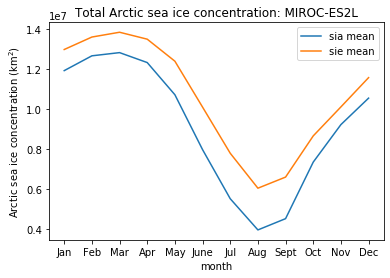

In [66]:
si_mon_mn.plot(label='sia mean')
sie_mon_mn.plot(label='sie mean')
#plt.fill_between(si_mon_mn.month,si_mon_mn-2*si_mon_std,si_mon_mn+2*si_mon_std,alpha=0.3)
plt.xticks(np.arange(1,13,1), month_lab)
plt.ylabel('Arctic sea ice concentration (km$^{2}$)')
plt.title('Total Arctic sea ice concentration: '+m)
plt.legend()

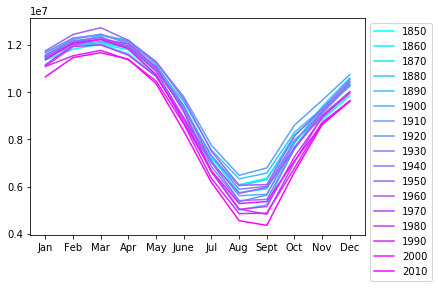

In [58]:
si_month = si_dict[m]['si_area_tot_arc'].isel(member_id=1).values.reshape(165,12)
colors = plt.cm.cool(np.linspace(0,1,165))
for y in range(0,165,10):
    plt.plot(np.arange(1,13,1),si_month[y,:],color=colors[y],label=str(y+1850))
plt.xticks(np.arange(1,13,1), month_lab)
plt.legend(bbox_to_anchor=(1,1))

### Scatter plots: 

In [139]:
tas_dict[m]['tas_arc_mean'] = arctic_mean(tas_dict[m],tas_dict[m].tas,70)

In [140]:
tas = tas_dict[m].tas_arc_mean.isel(member_id=0)
sie = si_dict[m]['si_extent_tot_nh'].isel(member_id=0)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


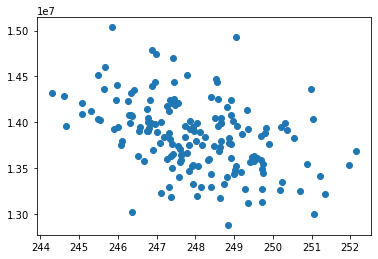

In [142]:
plt.scatter(tas[2::12],sie[2::12])